#### This notebook is designed to be a fairly verbose and expanded rendition of execution of a set of SAS Viya procedures using SAS CAS actions via Python in the Jupyter notebook interface.

##### Please note: this notebook was designed to be interpretable by the widest audience so many Python shortcut techniques have been expanded and are verbose by design.


In [1]:
#the swat package from SAS provides the interface to SAS via Python
from swat import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML

##### Start a CAS session

In [5]:
sess = CAS('localhost',5570, authinfo = '~/.authinfo')

##### Load SAS Actionsets

In [3]:
sas_actionsets = ['builtins','table','pca','decisionTree','sampling','percentile']
#loading SAS actionsets using list comprehension
[sess.loadactionset(actionset=i) for i in sas_actionsets]

NOTE: Added action set 'builtins'.
NOTE: Added action set 'table'.
NOTE: Added action set 'pca'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'percentile'.


[[actionset]
 
  'builtins'
 
 + Elapsed: 0.0298s, user: 0.005s, sys: 0.014s, mem: 0.132mb, [actionset]
 
  'table'
 
 + Elapsed: 0.00983s, user: 0.002s, sys: 0.013s, mem: 0.12mb, [actionset]
 
  'pca'
 
 + Elapsed: 0.046s, user: 0.013s, sys: 0.021s, mem: 0.129mb, [actionset]
 
  'decisionTree'
 
 + Elapsed: 0.0272s, user: 0.003s, sys: 0.024s, mem: 0.127mb, [actionset]
 
  'sampling'
 
 + Elapsed: 0.0915s, user: 0.016s, sys: 0.022s, mem: 0.133mb, [actionset]
 
  'percentile'
 
 + Elapsed: 0.0103s, user: 0.003s, sys: 0.014s, mem: 0.123mb]

##### Check Server Status

In [4]:
sess.builtins.serverstatus()

NOTE: Grid node action status report: 4 nodes, 22 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Copyright': 'Copyright © 2014-2016 SAS Institute Inc. All Rights Reserved.',
  'System': {'Hostname': 'apsrt3373',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '2.6.32-642.3.1.el6.x86_64',
   'OS Version': '#1 SMP Sun Jun 26 18:16:44 EDT 2016'},
  'Version': '3.01',
  'VersionLong': 'V.03.01M0P09072016',
  'license': {'expires': '15Dec2016:00:00:00',
   'gracePeriod': 20,
   'maxCPUs': 64,
   'site': 'UHC - VIYA',
   'siteNum': 70208500,
   'warningPeriod': 12}}

[server]

 Server Status
 
    nodes  actions
 0      4       22

[nodestatus]

 Node Status
 
         name        role   uptime  running  stalled
 0  apsrt3374      worker  355.707        0        0
 1  apsrt3375      worker  355.963        0        0
 2  apsrt3376      worker  356.029        0        0
 3  apsrt3373  controller  355.940        0        0

+ Elapsed: 0.032s, user: 0.003s, sys: 0.013s, mem: 0.146mb

##### Load the data set into CAS - distributed, in memory datastore

In [5]:
sms_topics = sess.upload("/htsasfin/int/datamart/prv/online/survey_ms_topics.sas7bdat")

NOTE: Cloud Analytic Services made the uploaded file available as table SURVEY_MS_TOPICS in caslib CASUSERHDFS(scroker).
NOTE: The table SURVEY_MS_TOPICS has been created in caslib CASUSERHDFS(scroker) from binary data uploaded to Cloud Analytic Services.


In [8]:
sess.tableInfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,SURVEY_MS_TOPICS,238,652,utf-8,07Dec2016:13:21:37,07Dec2016:13:21:37,UTF8,1.796736e+09,1.796736e+09,0,0,0,,,0,scroker,
1,SURVEY_TOPICS_PCAV,238,13,utf-8,07Dec2016:09:43:36,07Dec2016:09:43:36,UTF8,1.796723e+09,1.796723e+09,1,0,0,,,0,scroker,


##### Look at CAS library to ensure correct tables have been generated

In [31]:
#sess.tableinfo()
sess.tableinfo(caslib='HTSASFIN')

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,SURVEY_TOPICS_PCAV_PART,238,14,utf-8,07Dec2016:09:45:29,07Dec2016:09:45:29,UTF8,1.796723e+09,1.796723e+09,1,0,0,,,0,scroker,
1,FOREST_PCA_SCORE_MODEL,686,29,utf-8,07Dec2016:09:45:54,07Dec2016:09:45:54,UTF8,1.796723e+09,1.796723e+09,1,0,0,,,0,scroker,
2,SURVEY_TOPICS_SCORED,48,7,utf-8,07Dec2016:10:20:14,07Dec2016:10:20:14,UTF8,1.796725e+09,1.796725e+09,1,0,0,,,0,scroker,


##### Look at the CAS table

In [91]:
sms_columns = sms_topics.casTable.columnInfo().get('ColumnInfo')
def texttopic(element):
        if re.search(r"^(TextTopic_raw)[0-9]{1,2}$",element):
            return element

input_columns = [i for i in [texttopic(i) for i in sms_columns.Column] if i != None]
input_columns

['TextTopic_raw1',
 'TextTopic_raw2',
 'TextTopic_raw3',
 'TextTopic_raw4',
 'TextTopic_raw5',
 'TextTopic_raw6',
 'TextTopic_raw7',
 'TextTopic_raw8',
 'TextTopic_raw9',
 'TextTopic_raw10',
 'TextTopic_raw11',
 'TextTopic_raw12']

*SAS Viya PROC code that we are about to convert to CAS actions via Python:*
```
proc pca data=ifchcas.survey_ms_topics plots=(scree);
                var TextTopic_raw1--TextTopic_raw12;
                output out=ifchcas.survey_topics_pca score copyvars=(_all_);
run;
```


In [89]:
r = sess.table.dropTable(name='survey_topics_pcav')

NOTE: Cloud Analytic Services dropped table survey_topics_pcav from caslib CASUSERHDFS(scroker).


In [90]:
#note that the inputs are python lists and the output is a python dictionary
sms_pca = sess.eig(table = 'survey_ms_topics',
                    inputs = input_columns,
                    output={'casOut':{'name':'survey_topics_pcav',
                                      'promote':'True'
                                     },
                            'copyVars':'target'})
#display(sms_pca)

In [13]:
r = sess.table.droptable(caslib='HTSASFIN',name='survey_topics_pcav_part')

NOTE: Cloud Analytic Services dropped table survey_topics_pcav_part from caslib htsasfin.


In [14]:
sampled = sess.srs(output={'casOut':{'caslib':'HTSASFIN',
                                     'name':'survey_topics_pcav_part',
                                     'promote':True},
                           'copyVars':'all'},
                 samppct=20,
                 seed=42042,
                 table={'name':'survey_topics_pcav'},
                 partind=True
                )

NOTE: Added action set 'sampling'.
NOTE: Using SEED=42042 for sampling.


In [15]:
sms_topic_part = sess.CASTable(caslib='HTSASFIN',name='survey_topics_pcav_part')
training = sms_topic_part.query('0 = _partind_')
testing  = sms_topic_part.query('1 = _partind_')

##### Look at CAS library to ensure correct tables have been generated

In [16]:
sess.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,SURVEY_MS_TOPICS,238,652,utf-8,07Dec2016:09:42:38,07Dec2016:09:42:38,UTF8,1.796723e+09,1.796723e+09,0,0,0,,,0,scroker,
1,SURVEY_TOPICS_PCAV,238,13,utf-8,07Dec2016:09:43:36,07Dec2016:09:43:36,UTF8,1.796723e+09,1.796723e+09,1,0,0,,,0,scroker,


In [17]:
#sms_topic_part.columnInfo()

In [18]:
sess.tableinfo(caslib='HTSASFIN')

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,FOREST_PCA_SCORE_MODEL,686,29,utf-8,07Dec2016:08:31:45,07Dec2016:08:31:45,UTF8,1.796719e+09,1.796719e+09,1,0,0,,,0,scroker,
1,SURVEY_TOPICS_PCAV_PART,238,14,utf-8,07Dec2016:09:45:29,07Dec2016:09:45:29,UTF8,1.796723e+09,1.796723e+09,1,0,0,,,0,scroker,


``` proc forest data=CASUSER.SURVEY_TOPICS_PCA outmodel=ifchcas.forest_pca_model;
                partition fraction(validate=0.3);
                target target / level=nominal;
                input Score1 Score2 Score3 Score4 Score5 Score6 Score7 Score8 Score9 Score10 
                                Score11 Score12 / level=interval;
                autotune tuningparameters=(vars_to_try(init=1) ) maxtime=%sysevalf(10*60) 
                                maxiters=20 popsize=20;
                ods output FitStatistics=Work._Forest_FitStats_ 
                                VariableImportance=Work._Forest_VarImp_;
                score out=ifchcas.forest_pca_score copyvars=(_all_);
run;
```


In [19]:
r = sess.table.droptable(caslib='HTSASFIN',name='forest_pca_score_model')

NOTE: Cloud Analytic Services dropped table forest_pca_score_model from caslib htsasfin.


In [20]:
sms_forest = sess.foresttrain(
            table={'caslib':'HTSASFIN','name':'SURVEY_TOPICS_PCAV_PART','where':'_partind_ = 0'},
            target='target',
            nominals=['target'],
            inputs=['Score1','Score2','Score3','Score4','Score5','Score6',
                    'Score7','Score8','Score9','Score10','Score11','Score12'],
            bootstrap=.7,
            casOut={'caslib':'htsasfin','name':'forest_pca_score_model','promote':True},
            varImp='True',
            seed=42042,
            oob=True
            )
forestModel = sess.CASTable(caslib='htsasfin',name='forest_pca_score_model')

display(sms_forest)

NOTE: Added action set 'decisionTree'.


,Descr,Value
0,Number of Trees,50.000000
1,Number of Selected Variables (M),4.000000
2,Random Number Seed,42042.000000
3,Bootstrap Percentage (%),70.000000
4,Number of Bins,20.000000
5,Number of Variables,12.000000
6,Confidence Level for Pruning,0.250000
7,Max Number of Tree Nodes,23.000000
8,Min Number of Tree Nodes,11.000000
9,Max Number of Branches,2.000000


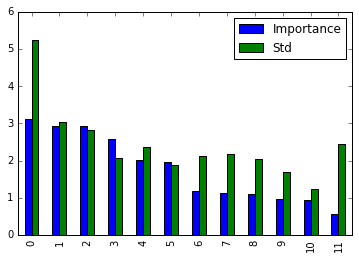

In [21]:
sms_forest.get('DTreeVarImpInfo').plot.bar()
#need to label the x axis

In [23]:
sess.forestScore(
    table={'caslib':'htsasfin','name':'SURVEY_TOPICS_PCAV_PART','where':'_partind_ = 1'},
    modelTable={'caslib':'htsasfin','name':'forest_pca_score_model'},
    copyVars=['_partind_','target'],
    casOut={'name':'sms_topics_forestScored','replace':True},
    vote='prob'
)

[OutputCasTables]

                  casLib                     Name  Rows  Columns  \
 0  CASUSERHDFS(scroker)  sms_topics_forestScored    48        7   
 
                                             casTable  
 0  CASTable('sms_topics_forestScored', caslib='CA...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            48
 1  Number of Observations Used            48
 2  Misclassification Error (%)  16.666666667

+ Elapsed: 0.266s, user: 0.067s, sys: 0.106s, mem: 28.8mb

In [24]:
sms_forest_scored = sess.CASTable('sms_topics_forestScored')
sms_forest_scored.computedVars=["P0","P1"]
sms_forest_scored.computedVarsProgram='''
   if '1' eq strip(_RF_PredName_) then do;
     P1 = _RF_PredP_;
     P0 = 1 - _RF_PredP_;
   end;
   else do;
     P1 = 1 - _RF_PredP_;
     P0 = _RF_PredP_;
   end;
'''

NOTE: Added action set 'percentile'.


In [25]:
sms_forest_scored.percentile.assess(
    casOut={"name":"forestAssess", "replace":True},
    nbins=10,
    cutStep = 0.01,
    inputs=['P1'],
    response='target', 
    event='1', 
    pVar=['P0'], 
    pEvent='0',
    includeLift=True,
    rocOut={'name':'forest_roc','replace':True}
)

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(scroker),forestAssess,10,21,"CASTable('forestAssess', caslib='CASUSERHDFS(s..."
1,CASUSERHDFS(scroker),forest_roc,100,20,"CASTable('forest_roc', caslib='CASUSERHDFS(scr..."
2,CASUSERHDFS(scroker),forestAssess_FITSTAT,1,6,"CASTable('forestAssess_FITSTAT', caslib='CASUS..."


In [28]:
forest_ROC = sess.CASTable('forest_ROC').to_frame()

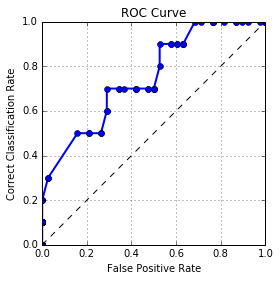

In [30]:
plt.figure(figsize=(4,4))
plt.plot(forest_ROC._FPR_,forest_ROC._Sensitivity_,'bo-',linewidth=2)
plt.plot(pd.Series(range(0,11,1))/10,pd.Series(range(0,11,1))/10,'k--',linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('Correct Classification Rate')
plt.grid(True)
plt.title('ROC Curve')
plt.show()

In [6]:
s = pd.DataFrame(sms_forest_scored.to_frame())
pd.crosstab(s.target,s._RF_PredName_)

NameError: name 'sms_forest_scored' is not defined

In [32]:
sess.close()